# Implementing RK1, RK2 and RK4 ODE Solvers

## Numerically Solving Higher Order Ordinary Differential Equations

A first order Ordinary Differential Equation (ODE) can be written in the form
$$\frac{dy(t)}{dt} = f(y(t), t)$$
Here, $y$ can be an $\mathbb{R}$-valued or vector-valued function. If $y(t) = (y_1(t), \ldots, y_k(t))$, then $\frac{dy(t)}{dt} = (\frac{dy_1(t)}{dt}, \ldots, \frac{dy_k(t)}{dt})$.

Higher order ODEs can also be converted to a system of first order ODEs and then represented as a single ODE of a vector-valued function. 

### Initial Value Problem (IVP)

An *Initial Value Problem* is an ODE together with the value of $y$ at some point $t_0$. The task then is to find a solution for $y$ in some interval $[a, b]$. (Usually $a = t_0$).

A unique solution is guaranteed if $f$ satisfies certain continuity conditions. [Picard–Lindelöf theorem](https://en.wikipedia.org/wiki/Picard%E2%80%93Lindel%C3%B6f_theorem).

### Numerical Solution

Solving an IVP analytically (symbollically) can be hard or even impossible (?). But there are multiple ways to solve any IVP numerically. The `solve_ivp` function in `numpy.integrate` supports five such methods - RK23, RK45, DOP853, BDF, LSODA, with RK45 being the default.

#### Example 1. Simple harmonic oscillation

\begin{align*}
    \frac{d}{dt} y_1 = y_2 \\
    \frac{d}{dt} y_2 = -y_1
\end{align*}

with initial conditions $y_1(0) = 0$ and $y_2(0) = 1$.

Solve it in the interval $[0,10]$

Note that this differential equation has an exact solution 
$$ y_1(t) = sin(t) $$
which you can use to check the accuracy of your numerical solutions

In [2]:
# Importing packages
from scipy import integrate
import matplotlib.pyplot as plt
import numpy as np
import math as math

In [3]:
def f(t,y):
    return np.array([y[1], -y[0]])# Defining the function where y[0] is the first derivative and y[1] is the second derivative

# Defining the initial conditions
y0 = [0,1]
a,b = 0,10 # Defining the range of the independent variable i.e. interval
t_eval = np.linspace(a,b,100) # Defining the number of points in the interval

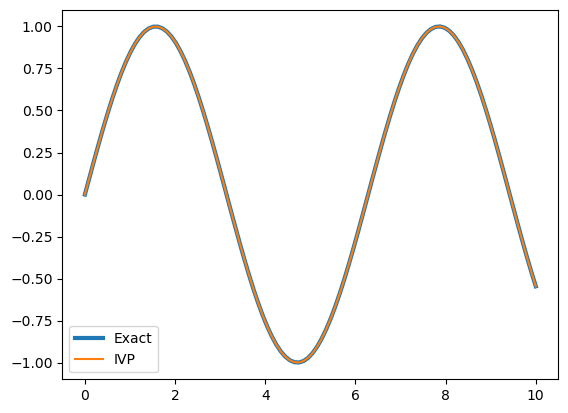

In [4]:
# Solve the IVP using the built-in function solve_ivp and compare the result with the exact solution
sol = integrate.solve_ivp(f, (a, b), y0, t_eval=t_eval) # Solving the IVP using the built-in function solve_ivp where f is the function, (a,b) is the interval, y0 is the initial conditions and t_eval is the number of points in the interval
y_ivp = sol["y"][0].copy() # Copying the solution of the IVP to y_ivp

y_exact = [math.sin(t) for t in t_eval] # Defining the exact solution of the IVP by using the formula y = sin(t)

plt.plot(t_eval, y_ivp, linewidth = 3, label="Exact")
plt.plot(t_eval, y_ivp, label="IVP")
plt.legend()

### What do these numerical methods do?

Solve the IVP
$$\frac{dy(t)}{dt} = f(y(t), t), \quad y(t_0) = y_0$$
in the interval $[t_0, t_f]$ for some $t_f > t_0$.

Let's start with $y$ being a scalar function.

### First order approximation (Forward Euler or First Order Runge-Kutta)

1. Sample a sequence of time points $t_0, t_1, \ldots, t_n = t_f$ from the interval $[t_0, t_f]$.
2. Estimate $y$ at $t_0, t_1, \ldots, t_f$.
\begin{align*}
    y_1 &= y_0 + f(y_0, t_0) (t_1 - t_0) \\
    y_2 &= y_1 + f(y_1, t_1) (t_2 - t_1) \\
    \ldots
\end{align*}
3. $y_i$ is our approximation for $y(t_i)$.

You can imagine $y_i$ as a vector of length same as the number of ODEs in the system.


In [5]:
# Implementing the forward euler method, with a similar interface to solve_ivp

def rk1(f, T, y0, t_eval = None):
    a, b = T # Defining the interval where a and b are the initial and final points
    if t_eval is None: # If t_eval is not defined
        t_eval = np.linspace(a, b, 100) # Defining the number of points in the interval
    
    y = np.zeros(shape=(len(y0), len(t_eval)))# Defining the shape of the array y with the number of points in the interval and the length of the initial conditions
    y[:,0] = y0 # Defining the initial conditions
    
    for i in range(1, len(t_eval)):
        t1, t2 = t_eval[i-1: i+1] # Defining the interval where t1 is the initial point and t2 is the final point in the interval
        y1 = y[:,i-1]
        h = t2-t1 # Defining the step size
        k1 = f(t1, y1)# Defining the first derivative
        y2 = y1 + h*k1# Defining the second derivative
        y[:,i] = y2 # Defining the solution of the IVP
    
    return {"t": t_eval, "y": y} # Returning the solution of the IVP    
        

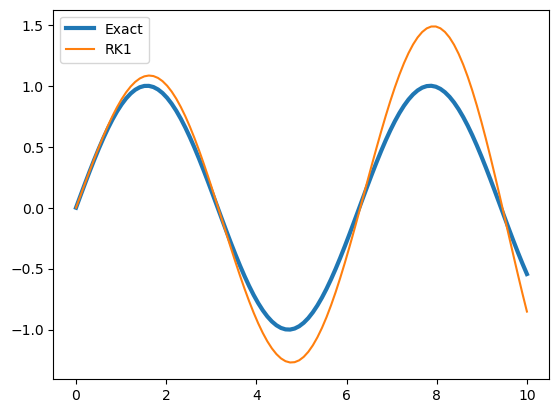

In [6]:
# Using rk1, solving the IVP and comparing the result with the exact solution and comparing the solutions
sol = rk1(f, (a,b), y0, t_eval = t_eval) # Solving the IVP using the built-in function solve_ivp where f is the function, (a,b) is the interval, y0 is the initial conditions and t_eval is the number of points in the interval

t_rk1 = sol["t"].copy() # Copying the solution of the IVP to t_rk1
y_rk1 = sol["y"][0].copy() # Copying the solution of the IVP to y_rk1

plt.plot(t_eval, y_exact, label="Exact", linewidth=3)
plt.plot(t_rk1, y_rk1, label="RK1")
plt.legend()

### Second order approximation (Runge-Kutta-2)

1. Sample a sequence of time points $t_0, t_1, \ldots, t_n = t_f$ from the interval $[t_0, t_f]$.
2. Estimate $y$ at $t_0, t_1, \ldots, t_f$.
\begin{align*}
    k_1  &= f(y_i, t_i) \\
    y'   &= y_i + k_1 (t_{i+1} - t_i) \\
    k_2  &= f(y', t_{i+1}) \\
    k &= (k_1 + k_2)/2 \\
    y_{i+1} &= y_1 + k (t_2 - t_1) \\
    \ldots
\end{align*}
4. $y_i$ is our approximation for $y(t_i)$.

#### Task-1: Implement the Second Order Runge-Kutta Method with A Similar Interface to `solve_ivp` 



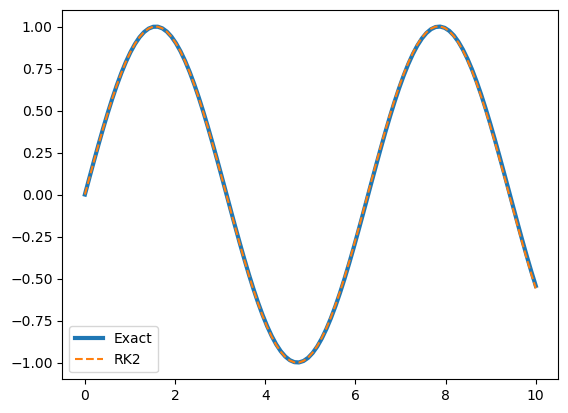

In [7]:
def rk2(f, T, y0, t_eval = None):
    a, b = T # Defining the interval where a and b are the initial and final points
    if t_eval is None:# If t_eval is not defined
        t_eval = np.linspace(a,b, 100)
    y = np.zeros(shape=(len(y0), len(t_eval)))# Defining the shape of the array y with the number of points in the interval and the length of the initial conditions
    y[:, 0] = y0 # Defining the initial conditions
    for i in range(1, len(t_eval)):
        t_prev = t_eval[i-1]# Defining the previous point in the interval
        t_next = t_eval[i]# Defining the next point in the interval
        h = t_next - t_prev # Defining the step size
        y_prev = y[:, i-1]# Defining the previous solution of the IVP
        k1 = f(t_prev, y_prev)# Defining the first derivative
        y_prime = y_prev + h*k1# Defining the second derivative
        k2 = f(t_next, y_prime)
        k_avg = (k1 + k2)/2 # Defining the average of the first and second derivative
        y_next = y_prev + h*k_avg
        y[:, i] = y_next
    return {"t": t_eval, "y": y}# Returning the solution of the IVP

# Solving using RK2 and comparing with the exact solution
sol_rk2 = rk2(f, (a,b), y0, t_eval = t_eval) # Solving the IVP using the built-in function solve_ivp where f is the function, (a,b) is the interval, y0 is the initial conditions and t_eval is the number of points in the interval
t_rk2 = sol_rk2["t"]
y_rk2 = sol_rk2["y"][0]# Copying the solution of the IVP to y_rk2

plt.figure()
plt.plot(t_eval, y_exact, label="Exact", linewidth=3)
plt.plot(t_eval, y_rk2, '--', label="RK2")
plt.legend()
plt.show()# Displaying the plot
        

### Fourth order approximation (Runge-Kutta-4)

1. Sample a sequence of time points $t_0, t_1, \ldots, t_n = t_f$ from the interval $[t_0, t_f]$.
2. Estimate $y$ at $t_0, t_1, \ldots, t_f$.
\begin{align*}
    t_m & = (t_i + t_{i+1})/2 \\
    k_1 &= f(y_i, t_i) \\
    y'  &= y_i + k_1 (t_m - t_i) \\
    k_2  &= f(y', t_m) \\
    y'  &= y_i + k_2 (t_m - t_i) \\
    k_3  &= f(y', t_m) \\
    y'  &= y_i + k_3 (t_2 - t_i) \\
    k_4  &= f(y', t_m) \\
    k &= (k_1 + 2k_2 + 2k_3 + k_4)/6 \\
    y_{i+1} &= y_1 + k (t_2 - t_1) \\
    \ldots
\end{align*}
3. $y_i$ is our approximation for $y(t_i)$.

#### Task-2,3, 4: Using RK2 and RK4, Solve the IVP for Which we Know the Exact Solution and Compare the Solutions


In [8]:
from scipy import integrate

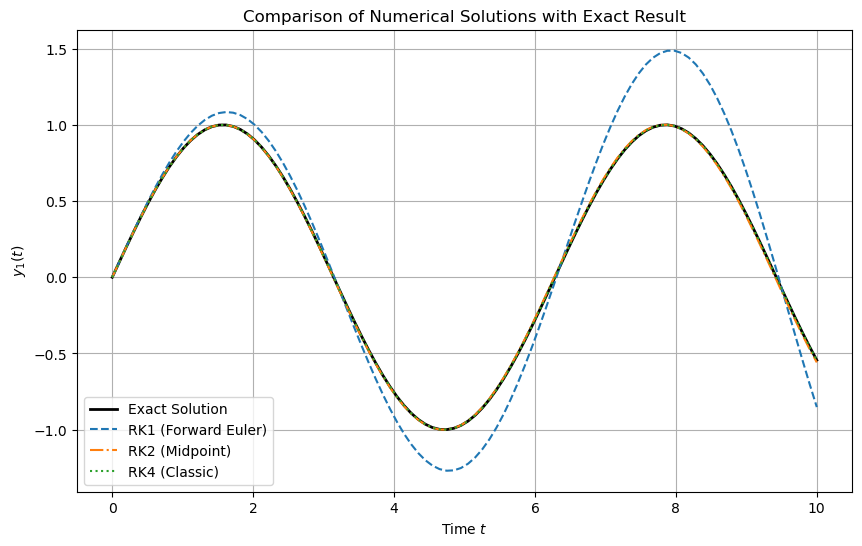

In [11]:
# Defining the ODE system for harmonic oscillator
def f(t,y):
    return np.array([y[1], -y[0]])

#Initial conditions and time span
y0 = [0,1]
t_Eval = np.linspace(a,b,100)
y_exact = np.sin(t_eval)


def rk1(f, T, y0, t_eval=None):
    a, b = T  
    if t_eval is None:  
        
        t_eval = np.linspace(a, b, 100)

    
    y = np.zeros(shape=(len(y0), len(t_eval)))
    y[:, 0] = y0 

    for i in range(1, len(t_eval)):
        
        t1, t2 = t_eval[i-1: i+1]
        y1 = y[:, i-1]
        h = t2-t1  
        k1 = f(t1, y1)  
        y2 = y1 + h*k1  
        y[:, i] = y2

    return {"t": t_eval, "y": y} 


def rk2(f, T, y0, t_eval=None):
    a, b = T  
    if t_eval is None:  
        t_eval = np.linspace(a, b, 100)
    
    y = np.zeros(shape=(len(y0), len(t_eval)))
    y[:, 0] = y0  
    for i in range(1, len(t_eval)):
        t_prev = t_eval[i-1]  
        t_next = t_eval[i] 
        h = t_next - t_prev  
        y_prev = y[:, i-1] 
        k1 = f(t_prev, y_prev) 
        y_prime = y_prev + h*k1
        k2 = f(t_next, y_prime)
        k_avg = (k1 + k2)/2
        y_next = y_prev + h*k_avg
        y[:, i] = y_next
    return {"t": t_eval, "y": y} 

def rk4(f, T, y0, t_eval=None): # Defining the function rk4 where f is the function, T is the interval, y0 is the initial conditions and t_eval is the number of points in the interval
    a, b = T # Defining the interval where a and b are the initial and final points
    if t_eval is None: 
        t_eval = np.linspace(a, b, 100)
    
    y = np.zeros(shape=(len(y0), len(t_eval))) # Defining the shape of the array y with the number of points in the interval and the length of the initial conditions
    y[:, 0] = y0 # Defining the initial conditions
    for i in range(1, len(t_eval)):
        t_prev = t_eval[i-1]
        t_next = t_eval[i]
        h = t_next - t_prev# Defining the step size
        y_prev = y[:, i-1]# Defining the previous solution of the IVP
        k1 = f(t_prev, y_prev)
        k2 = f(t_prev + h/2, y_prev + h*k1/2)
        k3 = f(t_prev + h/2, y_prev + h*k2/2)
        k4 = f(t_next, y_prev + h*k3)
        y_next = y_prev + h*(k1 + 2*k2 + 2*k3 + k4)/6
        y[:, i] = y_next
    return {"t": t_eval, "y": y}# Returning the solution of the IVP


# Solving and comparing with the exact solution
sol_rk1 = rk1(f, (a, b), y0, t_eval)
sol_rk2 = rk2(f, (a, b), y0, t_eval)
sol_rk4 = rk4(f, (a, b), y0, t_eval)

# Extract y1 components
y_rk1 = sol_rk1["y"][0]
y_rk2 = sol_rk2["y"][0]
y_rk4 = sol_rk4["y"][0]

# Plot comparison
plt.figure(figsize=(10, 6))
plt.plot(t_eval, y_exact, 'k-', linewidth=2, label="Exact Solution")
plt.plot(t_eval, y_rk1, '--', label="RK1 (Forward Euler)")
plt.plot(t_eval, y_rk2, '-.', label="RK2 (Midpoint)")
plt.plot(t_eval, y_rk4, ':', label="RK4 (Classic)")
plt.xlabel('Time $t$')
plt.ylabel('$y_1(t)$')
plt.title('Comparison of Numerical Solutions with Exact Result')
plt.legend()
plt.grid(True)
plt.show()

##### Analysing Error

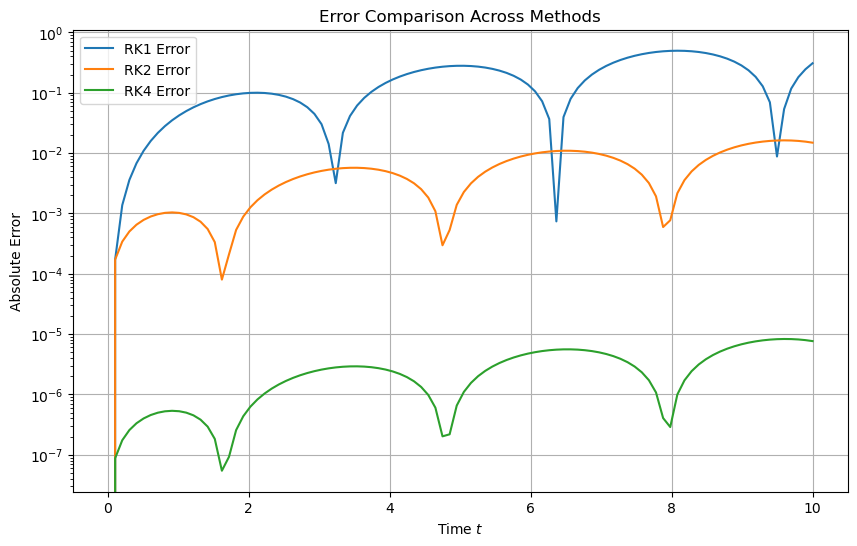

In [12]:
# Calculating absolute errors
error_rk1 = np.abs(y_rk1 - y_exact)
error_rk2 = np.abs(y_rk2 - y_exact)
error_rk4 = np.abs(y_rk4 - y_exact)

# Plotting errors
plt.figure(figsize=(10, 6))
plt.semilogy(t_eval, error_rk1, label="RK1 Error")
plt.semilogy(t_eval, error_rk2, label="RK2 Error")
plt.semilogy(t_eval, error_rk4, label="RK4 Error")
plt.xlabel('Time $t$')
plt.ylabel('Absolute Error')
plt.title('Error Comparison Across Methods')
plt.legend()
plt.grid(True)
plt.show()

#### Task-5: Compare All The Four Methods with The Exact Solution